# **Pervasice Data Science Seminar Project: Characterizing Drinks through WiFi analysis**


In [ ]:
from copy import deepcopy
from tqdm import tqdm
import time
import gc
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras_core as keras

## Data reading & preprocessing

In [ ]:
def read_csv(fname):
  with open(fname, encoding="utf8", errors="ignore") as f:
    a = f.read()[::2].split("\n")
  cols = a[0].strip().split(",")
  data = [x.split(",") for x in a[2::2]] # jump 2 because empty lines;
  data = [x[:-1] + [x[-1][1:-2].split(" ")] for x in data] # fixed csi_data format
  return pd.DataFrame(data, columns=cols)


def format_df(dataframe, unneeded_cols=[], seq_len=50, jump_skip=5):

  # transform CSI_DATA to numpy array, nothing else here
  CSI_DATA_np = np.zeros(shape=(len(dataframe["CSI_DATA"]), len(dataframe["CSI_DATA"][0])))
  for i, row in enumerate(dataframe["CSI_DATA"].iloc):
    CSI_DATA_np[i] = np.array(row)

  # reverse unneeded cols to needed cols instead
  needed_cols = np.array([i for i in range(CSI_DATA_np.shape[1]) if i not in unneeded_cols])

  skip_first_n_measurements = 20  # first measurements are noise probalby

  out = np.zeros(shape=(
      math.ceil((CSI_DATA_np.shape[0] - skip_first_n_measurements - seq_len) / jump_skip), # amount of sequences in output
      seq_len,  # each sequence length
      needed_cols.shape[0],   # each CSI_DATA datapoint
      ))

  for i, start_idx in enumerate(range(skip_first_n_measurements, CSI_DATA_np.shape[0] - seq_len, jump_skip)):
    out[i] = CSI_DATA_np[start_idx : start_idx + seq_len, needed_cols]

  return out


def make_dataset(files_and_classes, seq_len=50, jump_skip=5):
  """
  files and classes: [(file1, class1), (file2, class2)]
  seq_len: how many measurements are in a single datapoint
  """
  unneeded_cols = (
      list(range(0, 12)) +
      list(range(22, 24)) +
      list(range(50, 52)) +
      list(range(64, 66)) +
      list(range(78, 80)) +
      list(range(106, 108)) +
      list(range(118, 128))
    )

  dataset_X = None
  dataset_Y = []

  for (fname, label) in tqdm(files_and_classes):
    df = read_csv(fname)
    x = format_df(df, unneeded_cols, seq_len, jump_skip)

    # concat stuff from this file to the whole dataset
    dataset_X = x if dataset_X is None else np.concatenate((dataset_X, x), axis=0)
    dataset_Y += [label] * len(x)

  return dataset_X, dataset_Y

In [ ]:
X_train, y_train = make_dataset(
     [(f"inside_data/inside_water_close_train.csv", f"water")] +
     [(f"inside_data/inside_yogurt_close_train.csv", f"yogurt")] +
     [(f"inside_data/inside_beer_close_train.csv", f"beer")] +
     [(f"inside_data/inside_plumJuice_close_train.csv", f"plumJuice")] +
     [(f"inside_data/inside_water_close_train2.csv", f"water")] +
     [(f"inside_data/inside_yogurt_close_train2.csv", f"yogurt")] +
     [(f"inside_data/inside_beer_close_train2.csv", f"beer")] +
     [(f"inside_data/inside_plumJuice_close_train2.csv", f"plumJuice")],
     seq_len=100, jump_skip=1)

print("train data loaded")

X_test, y_test = make_dataset(
    [(f"inside_data/inside_water_close_val.csv", f"water")] +
    [(f"inside_data/inside_yogurt_close_val.csv", f"yogurt")] +
    [(f"inside_data/inside_beer_close_val.csv", f"beer")] +
    [(f"inside_data/inside_plumJuice_close_val.csv", f"plumJuice")] +
    [(f"inside_data/inside_water_close_val2.csv", f"water")] +
    [(f"inside_data/inside_yogurt_close_val2.csv", f"yogurt")] +
    [(f"inside_data/inside_beer_close_val2.csv", f"beer")] +
    [(f"inside_data/inside_plumJuice_close_val2.csv", f"plumJuice")],
    seq_len=100, jump_skip=1)

print("\nTest data loaded")

100%|██████████████████████████████████████████| 8/8 [00:17<00:00,  2.24s/it]


train data loaded


100%|██████████████████████████████████████████| 8/8 [00:05<00:00,  1.44it/s]


Test data loaded


In [ ]:
X_train.shape  # [Batch, seq_len, num_features]

(45473, 100, 96)

In [ ]:
len(y_train), y_train[:5]

(45473, ['water', 'water', 'water', 'water', 'water'])

In [ ]:
def labels_to_idxs(y):  # from strings to numbers
  out = np.zeros(len(y))
  for i in range(len(y)):
    out[i] = {"water": 0, "yogurt": 1, "beer": 2, "plumJuice": 3}[y[i]]
  return out

def idxs_to_labels(y):  # from numbers to strings
  out = [None] * len(y)
  for i in range(len(y)):
    out[i] = {0: "water", 1: "yogurt", 2: "beer", 3: "plumJuice"}[int(y[i])]
  return out

## Convolutional classifier

In [ ]:
def build_conv_model(input_shape, num_classes, layer_sizes, dropout, lr, l2_reg):
    input_layer = keras.layers.Input(input_shape)
    x = input_layer

    for i, size in enumerate(layer_sizes):
      x = keras.layers.Conv1D(filters=size, kernel_size=3, padding="same")(x)
      x = keras.layers.BatchNormalization()(x)
      x = keras.layers.ReLU()(x)
      if i != len(layer_sizes) - 1:
        x = keras.layers.Dropout(dropout)(x)

    gap = keras.layers.GlobalAveragePooling1D()(x)
    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(
      loss="sparse_categorical_crossentropy",
      optimizer=keras.optimizers.Adam(learning_rate=lr, weight_decay=l2_reg),
      metrics=["sparse_categorical_accuracy"],
    )
    return model

model = build_conv_model(
    input_shape=X_train.shape[1:],
    num_classes=4,
    layer_sizes=[128, 64, 32, 16, 8],
    dropout=0.1,
    lr = 1e-3,
    l2_reg=0.1,
)

model.summary()

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 100, 96)           │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_93 (Conv1D)              │ (None, 100, 128)          │     36,992 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_93          │ (None, 100, 128)          │        512 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ re_lu_93 (ReLU)                 │ (None, 100, 128)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_76 (Dropout)            │ (None, 100, 128)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_94 (Conv1D)              │ (None, 100, 64)           │     24,640 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_94          │ (None, 100, 64)           │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ re_lu_94 (ReLU)                 │ (None, 100, 64)           │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_77 (Dropout)            │ (None, 100, 64)           │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_95 (Conv1D)              │ (None, 100, 32)           │      6,176 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_95          │ (None, 100, 32)           │        128 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ re_lu_95 (ReLU)                 │ (None, 100, 32)           │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_78 (Dropout)            │ (None, 100, 32)           │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_96 (Conv1D)              │ (None, 100, 16)           │      1,552 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_96          │ (None, 100, 16)           │         64 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ re_lu_96 (ReLU)                 │ (None, 100, 16)           │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_79 (Dropout)            │ (None, 100, 16)           │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_97 (Conv1D)              │ (None, 100, 8)            │        392 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_97          │ (None, 100, 8)            │         32 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ re_lu_97 (ReLU)                 │ (None, 100, 8)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling1d_17     │ (None, 8)                 │          0 │
│ (GlobalAveragePooling1D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_17 (Dense)                │ (None, 4)                 │         3

 Total params: 70,780 (276.48 KB)

 Trainable params: 70,284 (274.55 KB)

 Non-trainable params: 496 (1.94 KB)

In [ ]:
class CustomEarlyStopping(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
      if logs['val_sparse_categorical_accuracy'] > 0.8:  # train until this val accuracy
          weights=self.model.get_weights()
          self.model.set_weights(weights)
          self.model.stop_training = True


model.fit(
    x=X_train,
    y=labels_to_idxs(y_train),
    epochs=2000,
    batch_size=8192,
    shuffle=True,
    validation_data=(X_test, labels_to_idxs(y_test)),
    callbacks=[CustomEarlyStopping()],
)


Epoch 1/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 707ms/step - loss: 1.3832 - sparse_categorical_accuracy: 0.2657 - val_loss: 1.4204 - val_sparse_categorical_accuracy: 0.2382
Epoch 2/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 435ms/step - loss: 1.3440 - sparse_categorical_accuracy: 0.3779 - val_loss: 1.4469 - val_sparse_categorical_accuracy: 0.2382
Epoch 3/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 431ms/step - loss: 1.3129 - sparse_categorical_accuracy: 0.3709 - val_loss: 1.5799 - val_sparse_categorical_accuracy: 0.2625
Epoch 4/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 414ms/step - loss: 1.2727 - sparse_categorical_accuracy: 0.3797 - val_loss: 1.8732 - val_sparse_categorical_accuracy: 0.2522
Epoch 5/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 427ms/step - loss: 1.2154 - sparse_categorical_accuracy: 0.4734 - val_loss: 2.1008 - val_sparse_categorical_accuracy: 0.2522
Epoch 6/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 458ms/step - loss: 1.1402 - sparse_categorical_accuracy: 0.5359 - val_loss: 3.1726 - val_sparse_categorical_accuracy: 0.2382
Epoc

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("loss, accuracy:", model.evaluate(X_test, labels_to_idxs(y_test), verbose=1))

y_prediction = np.argmax(model.predict(X_test), axis=-1)
_ = ConfusionMatrixDisplay(
  confusion_matrix=confusion_matrix(y_test, idxs_to_labels(y_prediction)),
  display_labels=["water", "yogurt", "beer", "plumJuice"],
).plot()

In [ ]:
model.save("models/model.h5")

## ROCKET

In [ ]:
from sktime.transformations.panel.rocket import Rocket
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.utils import all_estimators
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import warnings

In [ ]:
rocket = Rocket(n_jobs=6)

#rocket.fit(X_train)
rocket.fit(np.moveaxis(X_train, 1, 2))

print("fit done")

X_train_transform = rocket.transform(np.moveaxis(X_train, 1, 2))

print("train transform done")

X_test_trans = rocket.transform(np.moveaxis(X_test, 1, 2))

print("test transform done")

fit done
train trans done
test trans done


RandomForestClassifier: 0.23716364150010594
NearestCentroid: 0.2888622077830355
GaussianNB: 0.2884384490430115


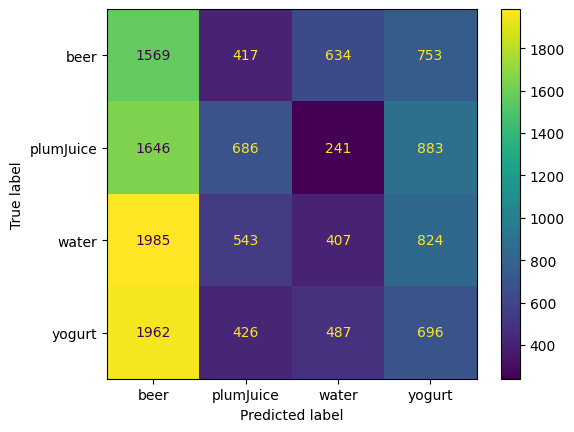

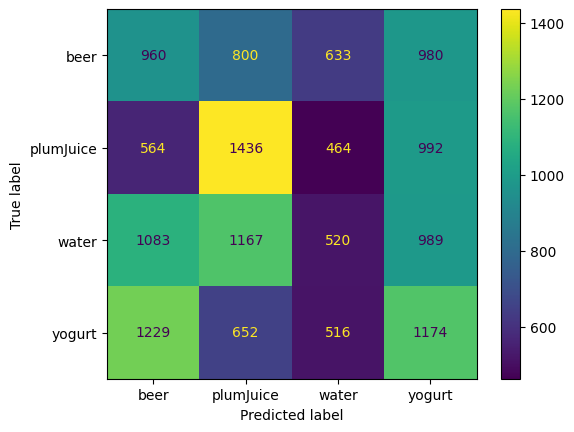

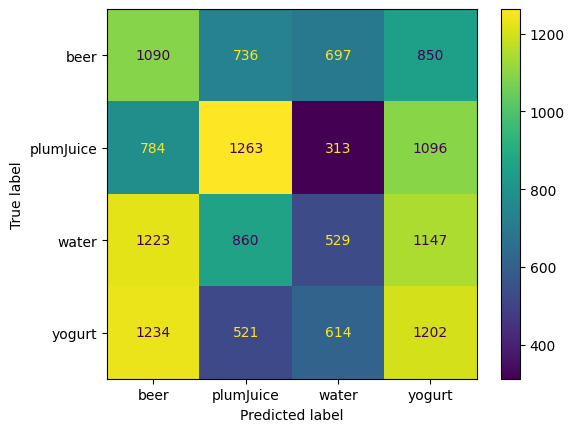

In [ ]:
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  for model in [("RandomForestClassifier", RandomForestClassifier(n_jobs=-1)), ("NearestCentroid", NearestCentroid()), ("GaussianNB", GaussianNB())]:#all_estimators(type_filter='classifier'):
    if model[0] in ("GradientBoostingClassifier", "AdaBoostClassifier", "BaggingClassifier", "GaussianProcessClassifier", "CalibratedClassifierCV", "HistGradientBoostingClassifier"):
      continue

    print(f"{model[0]}:", end=" ")
    try:
      clf = model[1]
      clf.fit(X_train_transform, y_train)

      print(clf.score(X_test_trans, y_test))

      _ = ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_test, clf.predict(X_test_trans)),
        display_labels=clf.classes_
      ).plot()
    except Exception as msg:
      print("-fail-", msg, flush=True)

## SKTIME classifiers

In [ ]:
from sktime.classification.deep_learning.cnn import *
from sktime.classification.deep_learning import *
from sktime.classification.dictionary_based import *
from sktime.classification.distance_based import *
from sktime.classification.early_classification import TEASER
from sktime.classification.feature_based import *
from sktime.classification.hybrid import *
from sktime.classification.interval_based import *
from sktime.classification.kernel_based import *
from sktime.classification.sklearn import *
from sktime.transformations.panel.rocket import Rocket
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import all_estimators
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import warnings
import numpy as np

In [ ]:


for model in [
    # ("CNNClassifier", CNNClassifier),
    # ("LSTMFCNClassifier", LSTMFCNClassifier),
    # ("FCNClassifier", FCNClassifier),
    # ("InceptionTimeClassifier", InceptionTimeClassifier),
    # ("SimpleRNNClassifier", SimpleRNNClassifier),
    # ("WEASEL", WEASEL),
    # ("MUSE", MUSE), # 0.1764
    # ("IndividualBOSS", IndividualBOSS),
    # ("BOSSEnsemble", BOSSEnsemble),
    # ("KNeighborsTimeSeriesClassifier", KNeighborsTimeSeriesClassifier),
    # ("KNeighborsTimeSeriesClassifierTslearn", KNeighborsTimeSeriesClassifierTslearn), # - tslearn
    # ("ProximityForest", ProximityForest),
    # ("ShapeDTW", ShapeDTW),
    # ("TEASER", TEASER),
    # ("Catch22Classifier", Catch22Classifier), # 0.6029
    # ("RandomIntervalClassifier", RandomIntervalClassifier), Failed in nopython mode pipeline
    # ("TSFreshClassifier", TSFreshClassifier),
    ("HIVECOTEV1", HIVECOTEV1(n_jobs=-1)),
    ("HIVECOTEV2", HIVECOTEV2(time_limit_in_minutes=10, n_jobs=-1)),
    # ("CanonicalIntervalForest", CanonicalIntervalForest),
    # ("TimeSeriesForestClassifier", TimeSeriesForestClassifier),
    # ("TimeSeriesSVC", TimeSeriesSVC),
    # ("RocketClassifier", RocketClassifier),
    # ("ContinuousIntervalTree", ContinuousIntervalTree),
    # ("RotationForest", RotationForest)
    ]:

  print(f"{model[0]}:", end=" ", flush=True)
  try:
    clf = model[1]
    clf.fit(np.moveaxis(X_train, 1, 2), y_train)

    print(clf.score(np.moveaxis(X_test, 1, 2), y_test))

    _ = ConfusionMatrixDisplay(
      confusion_matrix=confusion_matrix(y_test, clf.predict(np.moveaxis(X_test, 1, 2))),
      display_labels=clf.classes_
    ).plot()
  except Exception as msg:
    print("-fail-", msg, flush=True)

HIVECOTEV1: -fail- Data seen by HIVECOTEV1 instance has multivariate series, but this HIVECOTEV1 instance cannot handle multivariate series. Calls with multivariate series may result in error or unreliable results.
HIVECOTEV2: 

## CATCH22 classification

In [ ]:
import pycatch22
from tqdm import tqdm
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
def transform_row(x):
    res = np.zeros(shape=([x.shape[0], 22]))
    for feat in range(res.shape[0]):
      res[feat] = pycatch22.catch22_all(x[feat])["values"]
    return np.array(res)

def fast_catch22(data):
  transform = np.zeros(shape=([data.shape[0], data.shape[1] * 22]))

  from multiprocessing import Pool
  num_processes = 12

  with Pool(num_processes) as p:
      out = p.map(transform_row, [row for row in data])

  for b in range(transform.shape[0]):
    transform[b] = out[b].flatten()

  return transform

X_train_transform = fast_catch22(np.moveaxis(X_train, 1, 2))
X_test_transform = fast_catch22(np.moveaxis(X_test, 1, 2))

TRAIN DONE


BaggingClassifier: 0.2914753866798503
RandomForestClassifier: 0.3277067589519034


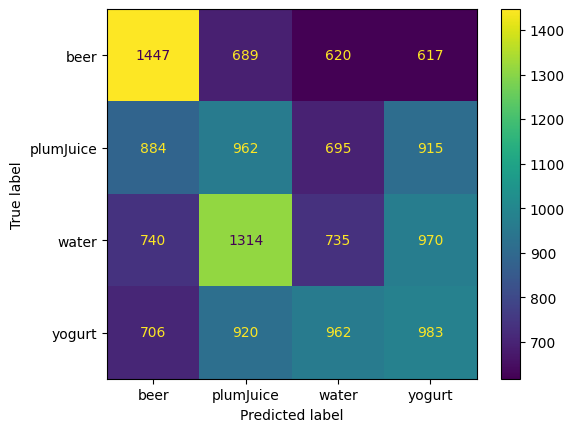

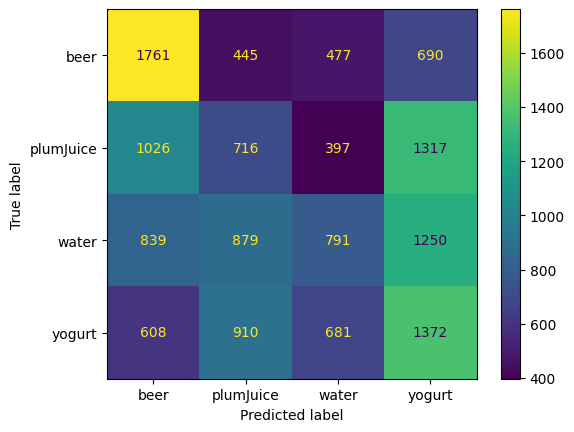

In [ ]:
with warnings.catch_warnings():
  warnings.simplefilter("ignore")

  for model in [("BaggingClassifier", BaggingClassifier(n_jobs=-1)),
                #("GradientBoostingClassifier", GradientBoostingClassifier()),
                #("HistGradientBoostingClassifier", HistGradientBoostingClassifier()),
                ("RandomForestClassifier", RandomForestClassifier(n_jobs=-1)),
                ]:

    print(f"{model[0]}:", end=" ")
    try:
      clf = model[1]
      clf.fit(X_train_transform, y_train)

      print(clf.score(X_test_transform, y_test))

      _ = ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_test, clf.predict(X_test_transform)),
        display_labels=clf.classes_
      ).plot()
    except Exception as msg:
      print("-fail-", msg, flush=True)
